In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_2Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText


[Qibo 0.1.7|INFO|2022-07-06 10:08:44]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-07-06 10:08:44]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-07-06 10:08:44]: Using tensorflow backend on /device:CPU:0


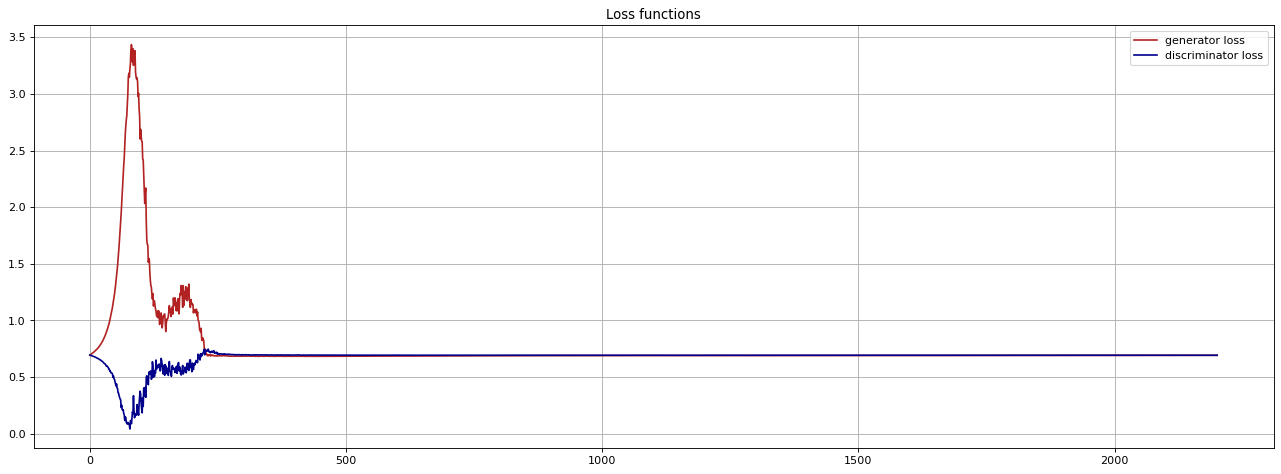

In [2]:
lr=[0.1,0.5]


d_loss = np.loadtxt(f"data/dloss_2Dgaussian_2_3_1_10000_128_0.1_0", delimiter=' ')
g_loss= np.loadtxt(f"data/gloss_2Dgaussian_2_3_1_10000_128_0.1_0", delimiter=' ')
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss',color="firebrick")
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss',color="darkblue")
pyplot.legend()
pyplot.title(f"Loss functions")
pyplot.grid()
pyplot.show()
 

In [5]:
def hamiltonian1():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(id, m0)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def hamiltonian2():
        id = [[1, 0], [0, 1]]
        m0 = hamiltonians.Z(1).matrix
        m0 = np.kron(m0,id)
        ham = hamiltonians.Hamiltonian(2, m0)
        return ham
    
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems
  

nqubits = 2
latent_dim=3
samples=5000
layers=1
# create hamiltonians
    
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
   
# create quantum generator
circuit = models.Circuit(nqubits)
circuit.add(gates.RY(1, 0))
for l in range(layers):
    for q in range(nqubits):
       
        circuit.add(gates.RZ(q, 0))
        
    #circuit.add(gates.CRY(0, 1, 0))
            
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))
    
params = np.loadtxt(f"data/PARAMS_2Dgaussian_2_3_1_10000_128_0.1_0", delimiter=' ', unpack='true')
#print(params,epochs)
params = tf.Variable(params)

fake_distr, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2)

#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)


fake_distr=tf.transpose(fake_distr)

training_samples=5000

s = qc.generate_training_real_samples(training_samples)
   
real_distr,_ = qc.generate_real_samples(samples, s, training_samples)
#print(real_distr)
real_distr=tf.transpose(real_distr)



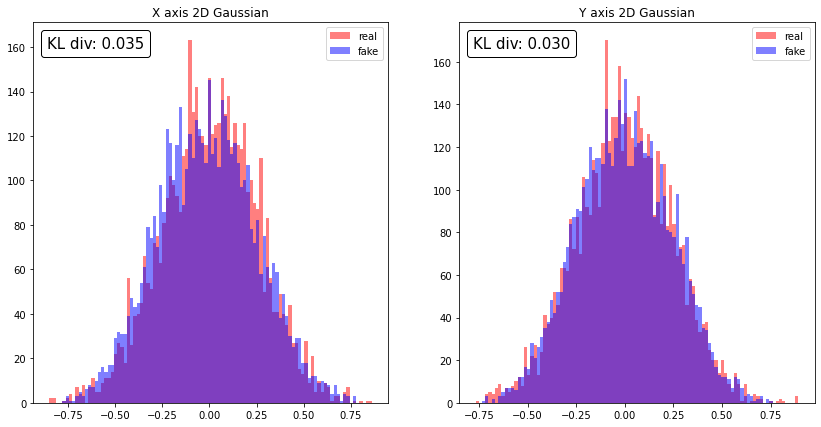

In [6]:
nbins=100

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(121)

bins_real=pyplot.hist(real_distr[0].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(fake_distr.numpy()[0], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

pyplot.legend()
pyplot.title("X axis 2D Gaussian")
at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


ax = fig.add_subplot(122)

bins_real=pyplot.hist(real_distr[1].numpy(), color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(fake_distr.numpy()[1], bins=bins_real[1],color='blue', label='fake', alpha=0.5)

pyplot.legend()
pyplot.title("Y axis 2D Gaussian")

at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


pyplot.show()

In [9]:
params = np.loadtxt(f"data/PARAMS_2Dgaussian_2_3_1_10000_128_0.1_0", delimiter=' ', unpack='true')
params = tf.Variable(params)    
x_fake, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2)
x_fake=tf.transpose(x_fake)
print (x_fake )

tf.Tensor(
[[-0.18088195  0.14886979  0.20907071 ...  0.08507937 -0.06896142
  -0.36281583]
 [ 0.13729375  0.21182128  0.14836277 ...  0.53552936 -0.12156082
  -0.12955798]], shape=(2, 5000), dtype=float64)


In [16]:
from scipy import stats
stat_moments_mean_x = []
stat_moments_err_x = []

stat_moments_mean_y = []
stat_moments_err_y = []

samples = 3000 
    
momentsx = [[] for j in range(4)]
momentsy = [[] for j in range(4)]

for k in range(4):
    params = np.loadtxt(f"data/PARAMS_2Dgaussian_2_3_1_10000_128_0.1_{k}", delimiter=' ', unpack='true')
    params = tf.Variable(params)    
    x_fake, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,hamiltonian2)
    x_fake = np.transpose(x_fake)
    
    momentsx[0].append(np.mean(x_fake[0]))
    momentsx[1].append(stats.moment(x_fake[0],moment=2))
    momentsx[2].append(stats.moment(x_fake[0],moment=3))
    momentsx[3].append(stats.moment(x_fake[0],moment=4))
    
    momentsy[0].append(np.mean(x_fake[1]))
    momentsy[1].append(stats.moment(x_fake[1],moment=2))
    momentsy[2].append(stats.moment(x_fake[1],moment=3))
    momentsy[3].append(stats.moment(x_fake[1],moment=4))


for k in range(len(momentsx)): 

    stat_moments_mean_x.append(np.mean(momentsx[k]))
    stat_moments_err_x.append(stats.moment(momentsx[k],moment=2))
    
    stat_moments_mean_y.append(np.mean(momentsy[k]))
    stat_moments_err_y.append(stats.moment(momentsy[k],moment=2))

print("x distribution")
print(stat_moments_mean_x, stat_moments_err_x)
print("y distribution")
print(stat_moments_mean_y, stat_moments_err_y)

x distribution
[0.0006203631094574818, 0.06438084626849847, 0.0002200317713676248, 0.011437093023353655] [0.0001025557316273802, 1.2719416798032846e-05, 3.410043774214647e-07, 1.381580052209144e-06]
y distribution
[0.0063593599070858615, 0.06231271080336384, 0.0004229048057212223, 0.010662562109585811] [4.34560365974921e-05, 5.1320480401640905e-06, 3.544126511136074e-07, 5.358354263289823e-07]


In [9]:
np.savetxt('fake_data.dat',tf.transpose(fake_distr))